In [80]:
import pysam as ps
import numpy as np
import collections
import matplotlib.pyplot as plt
from numpy.core.defchararray import array, center
import pysam as ps
import numpy as np
from collections import defaultdict
from scipy.ndimage.measurements import label, standard_deviation
from scipy.stats.mstats_basic import kstest, normaltest
from sklearn.cluster import KMeans
import sys
from scipy.signal import savgol_filter
import math
from subprocess import call
import os.path
from utils import Gene, TSS, Point
from scipy import stats
from sklearn import svm
import sympy
import math
from math import e
import random
from keras import Model
from keras.models import load_model
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import KFold
from keras.layers import Input,Conv2D,Activation,Dense,Lambda,Flatten,Embedding,PReLU,BatchNormalization,Bidirectional,LSTM
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
import copy
from sklearn.utils import shuffle

In [81]:
dic = {
    'gene':'./data/gene/GRCh37.gene.bed',
    'non_gene':'./data/gene/non_gene.bed',
    'non_gene_4':'./data/gene/non_gene_4.bed',
    'non_gene_2':'./data/gene/non_gene_2.bed',
    'fasta':'/home/jiay/Desktop/hg19/hg19.fa',
    'bam1':'./data/051.bam',
    'bam2':'./data/051_2.bam',
    'bam3':'./data/051_3.bam',
    'bam123':'./data/051_123.bam',
    'bam234':'./data/051_234.bam',
    'bam4':'./data/051_4.bam',
    'bam5':'./data/051_5.bam',
    'TSS_low':'./data/gene/low_expressed.bed',
    'TSS_HK':'./data/gene/HK.bed',
    'TSS_silent':'./data/gene/silent_gene_TSS.bed',
    'ATAC_hema_1':'./data/gene/ATAC_hema_1.bed',
    'ATAC_hema_2':'./data/gene/ATAC_hema_2.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Bcell':'./data/gene/ATAC_Bcell.bed',
    'ATAC_Brain':'./data/gene/ATAC_Brain.bed'
    }
TSS_HK = []
with open(dic['TSS_HK'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        if ll[0] in ['1','2','3']:
            TSS_HK.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_HK.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
        


TSS_NonGene = []
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_NonGene.append(TSS(ll[0], int(ll[1])+int(1000)))
# with open(dic['ATAC_Bcell'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['1','2','3'] and ll[2] == '0':
#             TSS_NonGene.append(TSS(ll[0],int(ll[1])))

bamfile = ps.AlignmentFile(dic['bam123'],'rb')

TSS_NonGene = TSS_NonGene[:len(TSS_HK)]

TSSes_x = TSS_HK + TSS_NonGene
TSSes_y = [1]*len(TSS_HK) + [0]*len(TSS_NonGene)
perm = random.sample(range(len(TSSes_x)),len(TSSes_x))
TSSes_x = np.array(TSSes_x)
TSSes_y = np.array(TSSes_y)
TSSes_x = TSSes_x[perm[:len(perm)]]
TSSes_y = TSSes_y[perm[:len(perm)]]
labels = TSSes_y
up = 1000
down = 1000

In [82]:
'''cnn_input'''
raw_data = []
for j, tss in enumerate(TSSes_x):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in bamfile.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    raw_data.append(distribution_matrix)
raw_data = np.array(raw_data)

cnn_x = []
for mat in raw_data:
    cnn_x.append(mat)
cnn_x = np.array(cnn_x)
x_train = cnn_x
y_train = np.array(labels)
# train_y = 

In [83]:
def create_model():
    cnn_input = layers.Input(shape=(cnn_x.shape[1], cnn_x.shape[2]), name='cnn_input')
    # lstm_input = Input(shape=(lstm_x.shape[1], lstm_x.shape[2]), name='lstm_input')
    x = layers.Convolution1D(filters=64, kernel_size=2, strides=1, activation='relu', padding='same',name='conv1')(cnn_input)
    x = layers.AveragePooling1D(pool_size=2, strides=2)(x)
    # x = layers.Dropout(0.2)(x)
    # conv1 = layers.Convolution1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='same',name='conv1')(cnn_input)
    # conv1 = layers.AveragePooling1D(pool_size=2, strides=2)(conv1)
    # conv1 = layers.Dropout(0.2)(conv1)

    x = layers.Bidirectional(layers.LSTM(50, return_sequences=True),name='0')(x)
    # x = layers.Convolution1D(filters=100, kernel_size=3, activation='relu',strides=1,padding='same',name='1')(x)
    # x = layers.MaxPooling1D(pool_size=2, strides=2,name='2')(x)
    # drop = Dropout(0.2)(pool)
    x = layers.Flatten()(x)
    x = layers.Dense(300, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(x)
    # drop = Dropout(0.2)(dense)
    # dense = Dense(16, activation='relu', kernel_regularizer=None, bias_regularizer=None,name='4')(flatten)
    # drop = Dropout(0.2)(dense)
    main_output = layers.Dense(1, activation='sigmoid', kernel_regularizer=None, bias_regularizer=None,name='6')(x)

    model = Model(inputs=cnn_input, outputs=main_output)
    return model

In [84]:
from tensorflow import keras
base_model = create_model()
base_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
base_model.fit(x_train,y_train,epochs=50,batch_size=256,shuffle=True, verbose=0)

/home/jiay/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [85]:
print(base_model.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cnn_input (InputLayer)       [(None, 200, 200)]        0         
_________________________________________________________________
conv1 (Conv1D)               (None, 200, 64)           25664     
_________________________________________________________________
average_pooling1d_15 (Averag (None, 100, 64)           0         
_________________________________________________________________
0 (Bidirectional)            (None, 100, 100)          46000     
_________________________________________________________________
flatten_13 (Flatten)         (None, 10000)             0         
_________________________________________________________________
4 (Dense)                    (None, 300)               3000300   
_________________________________________________________________
6 (Dense)                    (None, 1)                 301

In [86]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.NONE)
def get_loss0(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(tf.reshape(y, (-1,1)), tf.reshape(pred_y,(-1,1)))
def focal_loss(y_true, y_pred):
   gamma = 2.0
   alpha = 0.5
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def get_loss1(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(y_true = y, y_pred= np.array(pred_y).reshape(-1,1))
def get_loss(y_t, y_p):
    return loss_object(tf.reshape(y_t,(-1,1)), tf.reshape(y_p,(-1,1)))

l1_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)     
def loss_fn(yt, yp, ypp, ypp1, ypp2, gamma=0.5):
    l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    # l2 = K.mean(K.square(ypp - (ypp1+ypp2)/2), axis=-1)
    l2 = K.square(ypp1 - ypp2)
    # ypr = (ypp1 + ypp2)/2
    # l2 =tf.losses.binary_crossentropy(tf.reshape(ypr,(-1,1)), tf.reshape(ypp, (-1,1)))
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
# model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
nb_epochs = 50
batchsize = 256
pre_epochs = 5
lam = 0.3

model_a = create_model()
model_b = create_model()

model_a.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
x_train_0, y_train_0 = copy.copy(x_train), copy.copy(y_train)
x_train, y_train = shuffle(x_train, y_train)

model_a.fit(x_train, y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True,verbose=0)
model_b.fit(x_train, y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True,verbose=0)

from tqdm import tqdm

nb_batch = int(np.ceil(len(x_train) / batchsize))

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batchsize)
optimizer_a = keras.optimizers.SGD(learning_rate=1e-3)
optimizer_b = keras.optimizers.SGD(learning_rate=1e-3)
pre_a = model_a(x_train,training=False).numpy()
pre_b = model_b(x_train,training=False).numpy()
loss_a = get_loss(y_train, pre_a).numpy()
loss_b = get_loss(y_train, pre_b).numpy()
nb_batch = int(np.ceil(len(x_train)/batchsize))
for ep in tqdm(range(nb_epochs)):
    p_a = model_a(x_train,training=False)
    l_a = get_loss(y_train, p_a.numpy()).numpy()
    pre_a = lam * p_a.numpy() + (1-lam) * pre_a
    loss_a= lam * l_a + (1-lam) * loss_a
    p_b = model_b(x_train,training=False)
    l_b = get_loss(y_train, p_b.numpy()).numpy()
    pre_b = lam * p_b.numpy() + (1-lam) * pre_b
    loss_b = lam * l_b + (1-lam) * loss_b

    mean_a = np.mean(loss_a)
    data_ids_a = []
    semi_ids_a = []
    for id, ll in enumerate(loss_a):
        if ll < mean_a:
            data_ids_a.append(id)
        else:
            semi_ids_a.append(id)
    mean_b = np.mean(loss_b)             
    data_ids_b = []
    semi_ids_b = []
    for id, ll in enumerate(loss_b):
        if ll < mean_b:
            data_ids_b.append(id)
        else:
            semi_ids_b.append(id)

    for nb in range(nb_batch):
        start = nb * batchsize
        end = min((nb + 1) * batchsize, len(x_train))
        # x_batch_train, y_batch_train = x_train[start:end], y_train[start:end]
        tr_a_ids = []
        ex_a_ids = []
        tr_b_ids = []
        ex_b_ids = []
        for id in range(start,end):
            if id in data_ids_a:
                tr_a_ids.append(id)
            else:
                ex_a_ids.append(id)
            if id in data_ids_b:
                tr_b_ids.append(id)
            else:
                ex_b_ids.append(id)
   
        with tf.GradientTape() as tape_a:
            logits_a = model_a(x_train[tr_b_ids], training=True)
            log_a = model_a(x_train[ex_b_ids], training=False)

            loss_value_a = loss_fn(y_train[tr_b_ids], logits_a, log_a, pre_a[ex_b_ids], pre_b[ex_b_ids])
        grads_a = tape_a.gradient(loss_value_a, model_a.trainable_weights)
        optimizer_a.apply_gradients(zip(grads_a, model_a.trainable_weights))

        with tf.GradientTape() as tape_b:
            logits_b = model_b(x_train[tr_a_ids], training=True)
            log_b = model_b(x_train[ex_a_ids], training=False)
            # log_a = model_a(x_batch_train[semi_ids_a], training=False)
            loss_value_b = loss_fn(y_train[tr_a_ids], logits_b, log_b, pre_a[ex_a_ids], pre_b[ex_a_ids])
            # loss_value_b = get_loss(y_batch_train[data_ids_a], logits_b)
        grads_b = tape_b.gradient(loss_value_b, model_b.trainable_weights)
        optimizer_b.apply_gradients(zip(grads_b, model_b.trainable_weights))

100%|██████████| 50/50 [10:54<00:00, 13.09s/it]


In [97]:
'''test'''
TSS_test = []
# with open(dic['TSS_HK'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         if ll[0] in ['4']:
#             TSS_test.append(TSS(ll[0], int(int(ll[1])+1000)))
# with open(dic['ATAC_hema_1'],'r') as f:
#     for line in f:
#         ll = line.strip().split('\t')
#         TSS_test.append(TSS(ll[0], int((int(ll[1])+int(ll[2]))/2)))
with open(dic['non_gene'],'r') as f:
    for line in f:
        ll = line.strip().split('\t')
        TSS_test.append(TSS(ll[0], int(ll[1]), int(ll[2])))
TSS_test = TSS_test[:300]
test_data = []
testbam = ps.AlignmentFile(dic['bam123'])
for j, tss in enumerate(TSS_test):
    chrom = tss.chrom
    start = tss.pos - up
    end = tss.pos + down
#    distribution_matrix = np.zeros((int(up+down), 200), dtype=int)
    distribution_matrix = np.zeros((200,200),dtype=int)
    for r in testbam.fetch(chrom[-1], start-500, end + 500):
        if (not r.is_reverse) and (not r.is_unmapped) and (not r.mate_is_unmapped) and r.mate_is_reverse and 50 < abs(r.isize) < 250:
            if r.reference_start + abs(r.isize) < start:
                continue
            if r.reference_start >= end:
                continue
            if r.reference_start < start:
                continue
            if r.reference_start + abs(r.isize) > end:
                continue
            ss = max(0, r.reference_start - start)
            relative_isize = abs(r.isize)-50
            distribution_matrix[ss//10,relative_isize] += 1
    test_data.append(distribution_matrix)
test_data = np.array(test_data)

test_x = []
for mat in test_data:
    test_x.append(mat)
test_x = np.array(test_x)

In [98]:
print(len(TSS_test),len(test_x),len(test_data))

300 300 300


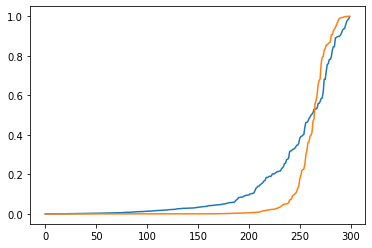

In [99]:
re_base = base_model(test_x).numpy()
re_base.sort(axis=0)
# print(test_x.shape)
plt.plot(np.arange(0,len(re_base),1),re_base,label='base')
re_a = model_a(test_x).numpy()
re_b = model_b(test_x).numpy()
re = (re_a + re_b) / 2
# re.reshape(1,-1)
re.sort(axis=0)

plt.plot(np.arange(0,len(re),1),re, label='co')
plt.show()
# print(re_a)

In [100]:
count_0 = 0
count_1 = 1
for rr in re:
    if rr >=0.5:
        count_0 += 1
for rr in re_base:
    if rr >= 0.5:
        count_1 += 1
print(count_0, count_1) 

35 39
